In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.multibody.parsing import Parser
import os
from pydrake.all import (
    LoadModelDirectives, ProcessModelDirectives, RevoluteJoint, 
    RationalForwardKinematics, CspaceFreePolytope, SeparatingPlaneOrder,
    RigidTransform, RotationMatrix, Rgba,
    AffineSubspace, MathematicalProgram, Solve,
    MeshcatVisualizer, StartMeshcat
)
import numpy as np
# from pydrake.geometry.optimization_dev import (CspaceFreePolytope, SeparatingPlaneOrder)
from iris_plant_visualizer import IrisPlantVisualizer
from pydrake.geometry import Role
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid, IrisInRationalConfigurationSpace
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions, ScsSolver
import time

In [3]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)

parser.package_map().Add("ciris_pgd", os.path.abspath(''))

directives_file = "/home/sgrg/rlg/SUPERUROP/ciris/models/iiwa14_sphere_collision_complex_scenario.dmd.yaml"
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()
meshcat = StartMeshcat()
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
diagram = builder.Build()
q0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, q0)
diagram.ForcedPublish(context)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [4]:
q_low = np.array([-2.967060,-2.094395,-2.967060,-2.094395,-2.967060,-2.094395,-3.054326])
q_high = np.array([2.967060,2.094395,2.967060,2.094395,2.967060,2.094395,3.054326])
idx = 0
for joint_index in plant.GetJointIndices():
    joint = plant.get_mutable_joint(joint_index)
    if isinstance(joint, RevoluteJoint):
        joint.set_default_angle(q0[idx])
        joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
        print(joint)
        idx += 1 

<RevoluteJoint name='iiwa_joint_1' index=1 model_instance=2>
<RevoluteJoint name='iiwa_joint_2' index=2 model_instance=2>
<RevoluteJoint name='iiwa_joint_3' index=3 model_instance=2>
<RevoluteJoint name='iiwa_joint_4' index=4 model_instance=2>
<RevoluteJoint name='iiwa_joint_5' index=5 model_instance=2>
<RevoluteJoint name='iiwa_joint_6' index=6 model_instance=2>
<RevoluteJoint name='iiwa_joint_7' index=7 model_instance=2>


In [5]:
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
# q_star = np.zeros(plant.num_positions())
q_star = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
do_viz = True

# The object we will use to perform our certification.
cspace_free_polytope = CspaceFreePolytope(plant, scene_graph, SeparatingPlaneOrder.kAffine, q_star)

In [6]:
from util import *
def AnimateIris(root_context, plant, visualizer, region, speed, num_moves=np.inf):
    """
    A simple hit-and-run-style idea for visualizing the IRIS regions:
    1. Start at the center. Pick a random direction and run to the boundary.
    2. Pick a new random direction; project it onto the current boundary, and run along it. Repeat
    """

    plant_context = plant.GetMyContextFromRoot(root_context)
    visualizer_context = visualizer.GetMyContextFromRoot(root_context)

    q = region.ChebyshevCenter()
    plant.SetPositions(plant_context, q)
    visualizer.ForcedPublish(visualizer_context)
    active_face = None

    print("Press the 'Stop Animation' button in Meshcat to continue.")
    meshcat.AddButton("Stop Animation", "Escape")

    rng = np.random.default_rng()
    nq = region.A().shape[1]
    prog = MathematicalProgram()
    qvar = prog.NewContinuousVariables(nq, "q")
    prog.AddLinearConstraint(
        region.A(), 0 * region.b() - np.inf, region.b(), qvar
    )
    cost = prog.AddLinearCost(np.ones((nq, 1)), qvar)

    count = 0
    while meshcat.GetButtonClicks("Stop Animation") < 1:
        count += 1
        if meshcat.GetButtonClicks("Stop Animation") > 0:
            break
        direction = rng.standard_normal(nq)
        cost.evaluator().UpdateCoefficients(direction)

        result = Solve(prog)
        assert result.is_success()

        q_next = result.GetSolution(qvar)

        # Animate between q and q_next (at speed):
        # TODO: normalize step size to speed... e.g. something like
        # 20 * np.linalg.norm(q_next - q) / speed)
        for t in np.append(np.arange(0, 1, speed), 1):
            qs = t * q_next + (1 - t) * q
            plant.SetPositions(plant_context, qs)
            if in_collision(plant, scene_graph, visualizer_context, print_collisions=True):
                print("In collision!")
            visualizer.ForcedPublish(visualizer_context)
            time.sleep(0.01)

        q = q_next

    meshcat.DeleteButton("Stop Animation")

In [8]:
import ipywidgets as widgets
from functools import partial

sliders = []
sliders.append(widgets.FloatSlider(min=q_low[0], max=q_high[0], value=0, description='q0'))
sliders.append(widgets.FloatSlider(min=q_low[1], max=q_high[1], value=0, description='q1'))

q = q0.copy()
def handle_slider_change(change, idx):
    q[idx] = change['new']
    visualizer.show_res_q(q)
    
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

for slider in sliders:
    display(slider)


FloatSlider(value=0.0, description='q0', max=1.7, min=-1.7)

FloatSlider(value=0.0, description='q1', max=1.7, min=-1.7)

In [ ]:
init_values = np.array([0.65, 0.1, 0.1, -1.57, -1.31, 0, 1, -1.38])
xyzrpy = init_values[:6]
left_psi = init_values[6]
right_psi = init_values[7]

q0 = np.zeros(7)
q1 = np.zeros(7)
visualize_state(q0, q1, plant, diagram, context)

full_valid_config_list = []

end_effector_sliders(meshcat, init_values=init_values)
ik_sliders(meshcat, init_psis=(left_psi, right_psi))

first_iter = True

num_clicks_iris = 0
num_clicks_connectivity = 0

meshcat.AddButton("Stop")
meshcat.AddButton("Toggle Guard")
meshcat.AddButton("Grow IRIS Region")
meshcat.AddButton("Plot Connectivity")
while meshcat.GetButtonClicks("Stop") < 1:
    q0_old = q0.copy()
    q1_old = q1.copy()
    xyzrpy_old = xyzrpy.copy()
    
    xyzrpy = np.array([meshcat.GetSliderValue(name)
              for name in ["x", "y", "z", "roll", "pitch", "yaw"]])
    
    xyz = xyzrpy[0:3]
    rpy = RollPitchYaw(xyzrpy[3], xyzrpy[4], xyzrpy[5])
    left_tf_goal = RigidTransform(rpy, xyz)
    
    left_GC2 = meshcat.GetSliderValue("left_GC2") * 2 - 1
    left_GC4 = meshcat.GetSliderValue("left_GC4") * 2 - 1
    left_GC6 = meshcat.GetSliderValue("left_GC6") * 2 - 1
    left_psi_old = left_psi
    left_psi = meshcat.GetSliderValue("left_psi")
    
    right_GC2 = meshcat.GetSliderValue("right_GC2") * 2 - 1
    right_GC4 = meshcat.GetSliderValue("right_GC4") * 2 - 1
    right_GC6 = meshcat.GetSliderValue("right_GC6") * 2 - 1
    right_psi_old = right_psi
    right_psi = meshcat.GetSliderValue("right_psi")
    
    if not first_iter:
        if meshcat.GetButtonClicks("Grow IRIS Region") > num_clicks_iris:
            num_clicks_iris = meshcat.GetButtonClicks("Grow IRIS Region")
            region = grow_region(np.hstack((q0, right_psi)))
            AnimateIris(context, plant, diagram, region, speed=0.01, num_moves=10)
            regions.append(region)

        if meshcat.GetButtonClicks("Plot Connectivity") > num_clicks_connectivity:
            num_clicks_connectivity = meshcat.GetButtonClicks("Plot Connectivity")
            if len(regions) > 0:
                notebook_plot_connectivity(regions)
                
    if first_iter or np.any(xyzrpy != xyzrpy_old) or left_psi != left_psi_old or right_psi != right_psi_old:
        q0 = analytic_ik.IK(left_tf_goal.GetAsMatrix4(),
                            [left_GC2, left_GC4, left_GC6], left_psi)

        right_tf_goal = RigidTransform(FK_fun(q0))

        q1 = analytic_ik.IK(right_tf_goal.GetAsMatrix4(),
                            [right_GC2, right_GC4, right_GC6], right_psi)

        plant_context = plant.GetMyContextFromRoot(context)
        plant.SetPositions(plant_context, np.hstack((q0, q1)))

        clear_output(wait=True)

        print(list(np.hstack((q0, right_psi))))

        for count, region in enumerate(regions):
            if region.PointInSet(np.hstack((q0, right_psi))):
                print("Point in region %d" % count)

        for num, q in zip([0,1], [q0,q1]):
            for i in range(len(q)):
                if q[i] < iiwa_limits_lower[i]:
                    print("q%d[%d] too low" % (num, i))
                if q[i] > iiwa_limits_upper[i]:
                    print("q%d[%d] too high" % (num, i))

        if(not_reachable(q0, left_psi, [left_GC2, left_GC4, left_GC6], analytic_ik, FK_fun)):
            print("Not reachable")

        if(in_collision(plant, scene_graph, context)):
            print("In collision")
    
    first_iter = False
    
    if meshcat.GetButtonClicks("Toggle Guard") % 2 == 1:
        visualize_state(q0, q1, plant, diagram, context)
        time.sleep(0.01)
        continue
    
    if np.any(q0 < iiwa_limits_lower) or \
       np.any(q0 > iiwa_limits_upper) or \
       np.any(q1 < iiwa_limits_lower) or \
       np.any(q1 > iiwa_limits_upper) or \
       not_reachable(q0, left_psi, [left_GC2, left_GC4, left_GC6], analytic_ik, FK_fun) or \
       in_collision(plant, scene_graph, context):
        xyzrpy = xyzrpy_old.copy()
        q0 = q0_old.copy()
        q1 = q1_old.copy()
        left_psi = left_psi_old
        right_psi = right_psi_old
        
        for slider_name, value in zip(
            ["x", "y", "z", "roll", "pitch", "yaw", "left_psi", "right_psi"],
            np.hstack((xyzrpy, [left_psi, right_psi]))):
            meshcat.SetSliderValue(slider_name, value)

        visualize_state(q0, q1, plant, diagram, context)
    elif np.any(q0 != q0_old) or np.any(q1 != q1_old) \
        or left_psi != left_psi_old or right_psi != right_psi_old:
        full_valid_config_list.append(np.hstack((q0, left_psi)))
        visualize_state(q0, q1, plant, diagram, context)
    
    time.sleep(0.01)
    
    break # Can remove to generate new regions

meshcat.DeleteAddedControls()

In [7]:
# Some seedpoints
seed_points_q = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

seed_points = np.array([Ratfk.ComputeSValue(seed_points_q[idx], q_star)\
                        for idx in range(seed_points_q.shape[0])])
# start = seed_points[0]
# end = seed_points[-1]

# visualizer.plot_cspace_points(seed_points, "/iris_seed_points", radius = 0.02)
# visualizer.plot_nontc_points(seed_points_q, "/iris_seed_points_q", radius = 0.02)

In [8]:
default_scale = 1e-2
L1_ball = HPolyhedron.MakeL1Ball(7)
Linf_ball = HPolyhedron.MakeBox(-np.ones(7), np.ones(7))

template_C = np.vstack([L1_ball.A(), Linf_ball.A()])
template_d = np.hstack([default_scale*L1_ball.b(), default_scale/np.sqrt(2)*Linf_ball.b()])


def make_default_polytope_at_point(seed_point):
    return HPolyhedron(template_C, template_d + template_C @ seed_point)


# colors to plot the region.
default_alpha = 0.2
colors_dict = {
    0: Rgba(0.565, 0.565, 0.565, default_alpha), # gray
    1: Rgba(0.118, 0.533, 0.898, default_alpha), # bluish
    2: Rgba(1,     0.757, 0.027, default_alpha), # gold
    3: Rgba(0,     0.549, 0.024, default_alpha), # green   
    4: Rgba(0.055, 0.914, 0.929, default_alpha), # teal 
}

initial_regions = [(make_default_polytope_at_point(s), colors_dict[i]) for i, s in enumerate(seed_points)]
# visualizer.add_group_of_regions_to_visualization(initial_regions, "initial_regions",
#                             wireframe = False,
#                            opacity = default_alpha)
# visualizer.show_res_q(q_star)

In [29]:
q_star

array([0., 0., 0., 0., 0., 0., 0.])

In [9]:
# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

os.environ["MOSEKLM_LICENSE_FILE"] = "/home/sgrg/mosek.lic"
with open(os.environ["MOSEKLM_LICENSE_FILE"], 'r') as f:
    contents = f.read()
    mosek_file_not_empty = contents != ''
print(mosek_file_not_empty)

solver_id = MosekSolver.id() if MosekSolver().available() and mosek_file_not_empty else ScsSolver.id()


solver_id = MosekSolver.id() if MosekSolver().available() else ScsSolver.id()

True


In [10]:
# The options for when we search for a new polytope given positivity certificates.
find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
find_polytope_given_lagrangian_option.solver_options = solver_options
find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True
find_polytope_given_lagrangian_option.ellipsoid_margin_epsilon = 1e-8
find_polytope_given_lagrangian_option.solver_id = solver_id

In [11]:
bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
bilinear_alternation_options.max_iter = 20 # Setting this to a high number will lead to more fill
bilinear_alternation_options.convergence_tol = 1e-3
bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option

# The options for when we search for new planes and positivity certificates given the polytopes
# find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
# find_separation_certificate_given_polytope_options.num_threads = -1
# Parallelism 	parallelism {Parallelism::Max()}
bilinear_alternation_options.find_lagrangian_options.verbose = True
bilinear_alternation_options.find_lagrangian_options.solver_options = solver_options
bilinear_alternation_options.find_lagrangian_options.ignore_redundant_C = False
bilinear_alternation_options.find_lagrangian_options.solver_id = solver_id

In [29]:
binary_search_options = CspaceFreePolytope.BinarySearchOptions()
binary_search_options.scale_min = 1
binary_search_options.scale_max = 50
binary_search_options.max_iter = 100
binary_search_options.find_lagrangian_options.verbose = True
binary_search_options.find_lagrangian_options.solver_options = solver_options
binary_search_options.find_lagrangian_options.ignore_redundant_C = False
binary_search_options.find_lagrangian_options.solver_id = solver_id
# binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

In [12]:
start = time.perf_counter()
iris_regions = []
iris_ellipses = []

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.configuration_space_margin = 1e-3
iris_options.relative_termination_threshold = 0.001

context_for_iris = context
for i, s in enumerate(seed_points):
    q = Ratfk.ComputeQValue(s, q_star)
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context_for_iris), q)
    r = IrisInRationalConfigurationSpace(plant, 
                                         plant.GetMyContextFromRoot(context_for_iris),
                                         q_star, iris_options)
    iris_regions.append((r, colors_dict[i]))
    iris_ellipses.append(r.MaximumVolumeInscribedEllipsoid())
end = time.perf_counter()
print("time taken ", end-start)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake:IrisInConfigurationSpace iteration 5
INFO:drake:IrisInConfigurationSpace iteration 6
INFO:drake:IrisInConfigurationSpace iteration 7
INFO:drake:IrisInConfigurationSpace iteration 8
INFO:drake:IrisInConfigurationSpace iteration 9
INFO:drake:IrisInConfigurationSpace iteration 10
INFO:drake:IrisInConfigurationSpace iteration 11
INFO:drake:IrisInConfigurationSpace iteration 12
INFO:drake:IrisInConfigurationSpace iteration 13
INFO:drake:IrisInConfigurationSpace: Terminating because the hyperellipsoid relative volume change 0.00035609548937206545 is below the threshold 0.001.


time taken  878.396675387994


In [27]:
region = iris_regions[0][0]
AnimateIris(context, plant, diagram, region, 0.01, num_moves=100)

Press the 'Stop Animation' button in Meshcat to continue.


In [ ]:
binary_search_region_certificates_for_iris = dict.fromkeys([tuple(s) for s in seed_points])
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, iris_regions)):
    print(f"starting seedpoint {i+1}/{len(iris_regions)}")
    time.sleep(0.2)
    cert = cspace_free_polytope.BinarySearch(set(),
                                                    initial_region.A(),
                                                    initial_region.b(), 
                                                    initial_region.MaximumVolumeInscribedEllipsoid().center(), 
                                                    binary_search_options)
    binary_search_region_certificates_for_iris[tuple(s)] = [(cert.certified_polytope(), cert, color)]

starting seedpoint 1/1


In [ ]:
# for i, result in enumerate(binary_search_region_certificates_for_iris.values()):
#     group_name = f"/certified-iris-bin_seed_point_{i}"
#     visualizer.add_group_of_regions_and_certs_to_visualization(result, group_name, 
#                                                             wireframe = False, opacity = 0.2)

In [19]:
regions = []
# for group_name, region_and_cert_list in visualizer.region_certificate_groups.items():
for i, result in enumerate(binary_search_region_certificates_for_iris.values()):
#     regions.extend([l[0] for l in region_and_cert_list])
    regions.extend(result)

In [20]:
len(regions)

4

In [21]:
regions_visualizer = [(region[0].ReduceInequalities(), region[2]) for region in regions]
regions = [(region[0].ReduceInequalities()) for region in regions]

In [ ]:
# visualizer.add_group_of_regions_to_visualization(regions_visualizer, "initial_regions",
#                             wireframe = True,
#                            opacity = default_alpha)

In [21]:
import visualization_utils as viz_utils
# viz_utils.plot_polytope(regions_visualizer[0][0], visualizer.meshcat_cspace, "test", wireframe=False)

In [22]:
from pgd import *
def get_step(values, indices, best_path, cost_func, gradient_func, step_size=0.01, backtracking=False, ndim=8):
    # R is a delay operator
    df_Rk = []
    last_common = 0
    f_Rk = 0
    # values = np.asarray(values)
    # t1 = time.perf_counter()
    for v in range(len(best_path[1:-1])):
        gradients = gradient_func(values[indices[v][0]:indices[v][1]])
        f_Rk += cost_func(values[indices[v][0]:indices[v][1]])
        if v==0:
            df_Rk.extend(gradients)
        else:
            # df_Rk[last_common-ndim:] += gradients[:ndim]
            for i in range(ndim):
                df_Rk[last_common-ndim+i] += gradients[i]
            df_Rk.extend(gradients[ndim:])
        last_common = len(df_Rk)
    # t2 = time.perf_counter()
    # print(t2-t1)
    df_Rk = np.asarray(df_Rk)

#     print(len(df_Rk))
    f_k = 0
    t1 = 0
    t2 = 0
    L_norm = 0
    t = 0
    
    beta = 0.5
    # https://www.cs.cmu.edu/~ggordon/10725-F12/scribes/10725_Lecture5.pdf
    if backtracking:
        # print('b', end='')
        t = 0.1
        t1 = time.perf_counter()
        x_k = values - t * df_Rk
        f_k = 0 # TODO: FIX THIS
        for v in range(len(best_path[1:-1])):
            f_k += cost_func(x_k[indices[v][0]:indices[v][1]])
        L_norm = df_Rk.dot(df_Rk)
        while f_k > (f_Rk - 0.5*t*(L_norm)):
            t = beta * t
            x_k = values - t * df_Rk
            f_k = 0
            for v in range(len(best_path[1:-1])):
                f_k += cost_func(x_k[indices[v][0]:indices[v][1]])
            # print(f_k, f_Rk, df_Rk.dot(df_Rk))

            t2 = time.perf_counter()
        # print(t2-t1)

        return x_k, f_k, t2-t1, t, L_norm
    else:
        return df_Rk*step_size*-1, f_k, t2-t1, t, L_norm

In [23]:
order = 3
start = Ratfk.ComputeSValue(np.array([-0.4, 0.1]), q_star)
goal = Ratfk.ComputeSValue(np.array([1.1, 1.0]), q_star)

ORDER = order
gcs, flows_result = generate_flows(start, goal, ORDER, regions, dim=2)
start_vertex, end_vertex = prune(gcs, flows_result, epsilon=0.00001)
print("pruned")
best_path, best_rounded_result = run_dfs(flows_result, gcs, start_vertex, end_vertex, iterations=5)
# ###############################

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 1000 rounding trials with Mosek.


Start vertex is  <pydrake.geometry.optimization.GraphOfConvexSets.Vertex object at 0x71ee4012ec30>   and end vertex is  <pydrake.geometry.optimization.GraphOfConvexSets.Vertex object at 0x71ee402a0eb0>
pruned
Cost for best path found   2.140282439151793


In [24]:
# # setup for PGD
variables, indices, h_list = generate_variable_list(best_path, ndim=2)
init_values = [best_rounded_result.GetSolution(x) for x in variables]
init_values.extend([best_rounded_result.GetSolution(h) for h in h_list])
init_values = np.asarray(init_values)

import numpy.linalg as la
# # iterate until infeasible.
# # get constraints and put into HPolyhedron - should be the same as 
prog, _ = prog_with_constraints(variables, best_path, start, goal, indices, 2, h_list)

In [25]:
print("program set")
hpoly = HPolyhedron(prog)
# is A necessary?
A = hpoly.A()
b = hpoly.b()
# create affine subspace
A_eq, b_eq = get_equality_matrices(prog)
U, S, V = la.svd(A_eq)

# nullspace is spanned by the last n-r columns of V
# rank is almost zero entries along the diagonal of S
r = (S>0.00001).sum()
basis = V[r:]
translation = la.pinv(A_eq).dot(b_eq)

affine_sub = AffineSubspace(basis.T, translation)

program set


In [26]:
gcs, flows_result = generate_flows(start, goal, ORDER, regions, dim=2)

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 1000 rounding trials with Mosek.


In [27]:
# start = seed_points_q[0]
from pydrake.all import GcsTrajectoryOptimization, Point, GraphOfConvexSetsOptions
order = 3
gcs = GcsTrajectoryOptimization(2)
main_graph = gcs.AddRegions(regions, order, h_min=0.1, h_max=100, name="")
start_graph = gcs.AddRegions([Point(start)], 0)
goal_graph = gcs.AddRegions([Point(goal)], 0)
gcs.AddEdges(start_graph, main_graph)
gcs.AddEdges(main_graph, goal_graph)

# gcs.AddTimeCost(1000)
gcs.AddPathLengthCost()
gcs.AddPathContinuityConstraints(2)

options = GraphOfConvexSetsOptions()
options.max_rounding_trials = 1000
options.max_rounded_paths = 100
options.convex_relaxation = True

traj, _ = gcs.SolvePath(start_graph, goal_graph, options)
traj.value(0)

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 1000 rounding trials with Mosek.


array([[-0.84228838],
       [-0.48305507]])

## Running PGD

In [92]:
t1_start = perf_counter() 
init_values = [best_rounded_result.GetSolution(x) for x in variables]
init_values.extend([best_rounded_result.GetSolution(h) for h in h_list])
init_values = np.asarray(init_values)
 
iters = 50
eps = 1e-7
qps_solved = 0
iter_costs = []
x_axis = []
times = []
t_grads = []
t_bt = []
t_qp = []
bt_costs = []
time_steps = []
lnorms = []
running_qp_project = []
termin = []
total_ts = []
costs_ts = []
qp, _ = prog_with_constraints(variables, best_path, start, goal, indices, 2, h_list)
init_values, qp_c = run_qp_proj(variables, init_values, best_path, start, goal, indices, h_list, qp)
print('setup')

setup


In [93]:
from jax import grad
import jax
# define costfn
jax.clear_caches()
costfn = jax.jit(distance_for_vertex, backend="cpu")
t1 = perf_counter()
costfn(init_values[indices[0][0]:indices[0][1]])
t2 = perf_counter()
print("warm start costfn took ", t2 - t1)

warm start costfn took  0.7016762330022175


In [94]:
grad_cost = grad(distance_for_vertex)
grad_jit = jax.jit(grad_cost, backend='cpu')
t1 = perf_counter()
grad_jit(init_values[indices[1][0]:indices[1][1]])#.block_until_ready()
t2 = perf_counter()
t2 - t1

1.8280335789968376

In [95]:
investigative_trajs = []
exp_avg = 0
moving_avg = 0
diff_termin = []
window = 5
i = 0
# for i in range(1):
while (len(diff_termin)==0 or abs(diff_termin[-1])>0.005) and i < 70:
    total_start = perf_counter()
    grad_time = perf_counter()
#     print('.')
#     bt_cost, bt_time, ts, l_norm = 0, 0, 0, 0
    init_values[:len(variables)], bt_cost, bt_time, ts, l_norm = get_step(init_values[:len(variables)], indices, best_path, costfn, grad_jit, step_size=0.01, backtracking=True, ndim=2)
#     init_values[:len(variables)] = get_step(init_values[:len(variables)], indices, best_path, costfn, grad_jit, step_size=0.005, backtracking=False)
    grad_time_stop = perf_counter()
#     print(grad_time_stop - grad_time)
    #### NOT TIMED #####
    t_grads.append(grad_time_stop - grad_time)
    t_bt.append(bt_time)
    bt_costs.append(bt_cost)
    time_steps.append(ts)
    lnorms.append(l_norm)
    ## NOT TIMED FIN ##
    qp_time = perf_counter()
    cheap_proj = affine_sub.Projection(init_values)[1].T[0] # DOUBLE CHECK THE SHAPE OF THIS
    if not hpoly.PointInSet(cheap_proj):
        init_values, qp_c = run_qp_proj(variables, cheap_proj, best_path, start, goal, indices, h_list, qp, qp_c)
        qps_solved += 1
        running_qp_project.append(True)
    else:
        init_values = cheap_proj
        running_qp_project.append(False)
    qp_time_stop = perf_counter()
    #### NOT TIMED #####
    t_qp.append(qp_time_stop - qp_time)
    cost = 0
    cost_calc_start = perf_counter()
    for v in range(len(best_path[1:-1])):
        cost += costfn(init_values[indices[v][0]:indices[v][1]])
        if cost!=cost:
            print(v, i)
    iter_costs.append(cost)
    if len(iter_costs) >= window:
        moving_avg_new = sum(iter_costs[-window:])/window
        termin.append(moving_avg_new)
        if moving_avg != 0:
            diff_termin.append((moving_avg_new - moving_avg)/moving_avg)
        moving_avg = moving_avg_new
#     exp_avg_new = alpha * cost + (1-alpha) * exp_avg
#     exp_avg = exp_avg_new
#     if len(iter_costs) > 4:
#         moving_avg_new = sum(iter_costs[-5:])/5
#         termin.append(moving_avg_new)
#         diff_termin.append((moving_avg_new - moving_avg)/moving_avg)
#         moving_avg = moving_avg_new
    cost_calc_stop = perf_counter()
    costs_ts.append(cost_calc_stop-cost_calc_start)
    x_axis.append(i)
    times.append(perf_counter()-t1_start)
    if i % 10 == 0:
#         qp, _ = prog_with_constraints(variables, best_path, start, goal, indices, h_list)
        print("     ")
    print('.', end='')
    ## NOT TIMED FIN ##
    total_end = perf_counter()
    total_ts.append(total_end-total_start)
    i += 1
#     if i>70:
#         investigative_trajs.append(trajectorify_given_vars(best_path, init_values, indices))
#     else if i==79:
        
t1_stop = perf_counter() 
cost = 0
for v in range(len(best_path[1:-1])):
    cost += costfn(init_values[indices[v][0]:indices[v][1]])
times.append(perf_counter()-t1_start)
iter_costs.append(cost)
x_axis.append(i)

print("Solve time:", t1_stop - t1_start, "QPs run", qps_solved, "iteration_costs", iter_costs)

     
......Solve time: 4.003890148997016 QPs run 6 iteration_costs [Array(3.3618877, dtype=float32), Array(3.365778, dtype=float32), Array(3.3663993, dtype=float32), Array(3.366781, dtype=float32), Array(3.366707, dtype=float32), Array(3.3661795, dtype=float32), Array(3.3661795, dtype=float32)]


In [96]:
traj_pgd = trajectorify_given_vars(best_path, init_values, indices, ndim=2)
traj_og = trajectorify_given_vars(best_path, [best_rounded_result.GetSolution(x) for x in variables], indices, ndim=2)

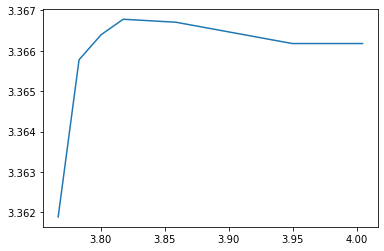

In [97]:
import matplotlib.pyplot as plt
plt.plot(times, iter_costs)

In [ ]:
traj_pgd.end_time()

In [ ]:
len(init_values)
ndim

In [ ]:
len(best_path)

In [ ]:
# dumb init
pts = np.squeeze(np.array([np.arctan(traj.value(it * traj.end_time() / 100)) for it in range(100)]))

In [ ]:
# np.hstack([pts, 0 * np.ones((pts.shape[0], 3 - pts.shape[1]))]).T
pts.shape

In [98]:
# # visualize path given trajectory
import visualization_utils as viz_utils
# viz_utils.draw_traj(visualizer.meshcat_cspace, traj, 100)
# viz_utils.draw_nontc_traj(visualizer.meshcat_nontc, traj, 100, q_star=q_star)
# visualizer.animate_traj_s(traj, 100, 100)
viz_utils.draw_traj(visualizer.meshcat_cspace, traj_og, 100)
viz_utils.draw_nontc_traj(visualizer.meshcat_nontc, traj_og, 100, q_star=q_star)
visualizer.animate_traj_s(traj_og, 100, 100)
viz_utils.draw_traj(visualizer.meshcat_cspace, traj_pgd, 100)
viz_utils.draw_nontc_traj(visualizer.meshcat_nontc, traj_pgd, 100, q_star=q_star)
visualizer.animate_traj_s(traj_pgd, 100, 100)

## Validating Paths?

In [100]:
# take a path
# calculate the q value at each point along the trajectory
# Sum all of them
def length_of_traj(traj):
    q_prev = np.array([0.3, 1.0])
    dist = 0
    for i in range(50):
        s = traj.value(traj.end_time()*i/50)
        q = Ratfk.ComputeQValue(s, q_star)
        dist += ((q - q_prev).dot(q - q_prev))**0.5
        q_prev = q
    return dist
new_len = length_of_traj(traj_pgd)
og_len = length_of_traj(traj_og)
print(new_len, og_len)

4.377200667606015 4.387048193241586


In [101]:
(og_len - new_len) / og_len

0.0022446814353992545

In [42]:
q_star

array([1., 1.])

In [49]:
traj_og.end_time()

3.0

In [50]:
traj_pgd.end_time()

3.0

In [56]:
iter_dist = 0
values = init_values
for v in range(len(best_path[1:-1])):
    iter_dist += distance_for_vertex(values[indices[v][0]:indices[v][1]])

In [57]:
iter_dist

Array(3.3586519, dtype=float32)

In [58]:
iter_dist = 0
values = [best_rounded_result.GetSolution(x) for x in variables]
for v in range(len(best_path[1:-1])):
    iter_dist += distance_for_vertex(values[indices[v][0]:indices[v][1]])

In [59]:
iter_dist

Array(3.3597455, dtype=float32)

In [99]:
q_star

array([1., 1.])

## 7 DOF IIWA

In [5]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)

parser.package_map().Add("ciris_pgd", os.path.abspath(''))

directives_file = "/home/sgrg/rlg/SUPERUROP/ciris/models/iiwa14_sphere_collision_complex_scenario.dmd.yaml"
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)


# oneDOF_iiwa_file = "/home/sgrg/rlg/SUPERUROP/ciris/assets/oneDOF_iiwa7_with_box_collision.sdf"
# with open(one|DOF_iiwa_file, 'r') as f:
#     oneDOF_iiwa_string = f.read()
# box_asset_file = "/home/sgrg/rlg/SUPERUROP/ciris/assets/box_small.urdf"
# with open(box_asset_file, 'r') as f:
#     box_asset_string = f.read()